## Simple analysis to calculate the speckle grain
which will eventually give our resolution (the smallest focus spot that we are able to achieve with the slm) and the size of macropixels we will use later on

    a. take a photo of the speckle
    b. check the histogram - it should be similar to a thermal distribution
    c. calculate the autocorrelation function - it should give a single peak
    d. check the peak width -> speckle grain
    
for this experiment we have used a thorlabs diffuser
https://www.thorlabs.com/thorproduct.cfm?partnumber=ED1-C20

#### import libraries

In [8]:
from slmOptim.zeluxPy.helper_functions import get_interferogram
from slmOptim.zeluxPy import helper_functions as cam

from matplotlib import pyplot as plt
from scipy import optimize
import scipy.fftpack as sfft
import numpy as np
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
def hist(array):
   counts, bins = np.histogram(array, bins=100)
   return counts, bins

def calc_acf(array):
   # fft of the speckle image
   fft = sfft.fft2(array)
   # power spectrum of fft
   power_spec = np.abs(fft) ** 2
   # inverse fft of power specturm + center freq
   acf = sfft.ifft2(power_spec).real
   acf_shift = sfft.fftshift(acf)
   
   return acf_shift
   
def gaussian_func(x, a, x0, sigma, b):
   return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + b


def fit_gaussian(array, init_values=[1e9, 50, 20, 6.5e8]):
   y_data = array
   x_data = range(0,len(y_data))
   
   params, _ = optimize.curve_fit(gaussian_func, x_data, y_data,
                                           p0=init_values, 
                                           bounds=((0, -np.inf, 0, -np.inf), 
                                                   (np.inf, np.inf, np.inf, np.inf)))
   
   return params

def plot(data):
   # plot a 2x2 figure
   fig, axs = plt.subplots(2, 2, figsize=(10, 10))
   
   #figure 1
   speckle = axs[0, 0].imshow(data['speckle'])
   axs[0, 0].set_xlabel('x (px)')
   axs[0, 0].set_ylabel('y (px)')
   axs[0, 0].set_title('Speckle pattern')
   divider = make_axes_locatable(axs[0, 0])
   cax = divider.append_axes("right", size="5%", pad=0.05)
   fig.colorbar(speckle, cax=cax)   

   # figure 2
   counts, bins = data['hist']
   axs[0, 1].hist(bins[:-1], bins, weights=counts)
   axs[0, 1].set_xlabel('intensity (a.u.)')
   axs[0, 1].set_ylabel('counts #')  
   axs[0, 1].set_title('Histogram')
   axs[0, 1].set_box_aspect(1)

   # figure 3
   acf = axs[1, 0].imshow(data['acf'])
   axs[1, 0].set_xlabel('x (px)')
   axs[1, 0].set_ylabel('y (px)')
   axs[1, 0].set_title('Autocorrelation function')
   divider = make_axes_locatable(axs[1, 0])
   cax = divider.append_axes("right", size="5%", pad=0.05)
   fig.colorbar(acf, cax=cax)   

   # figure 4
   y_data = data['acf'][50]
   x_data = range(0, len(y_data))
   axs[1, 1].plot(x_data, y_data, x_data, data['fit'])
   axs[1, 1].set_xlabel('x (px)')
   axs[1, 1].set_ylabel('intensity (a.u.)')
   axs[1, 1].legend(['raw', 'fit'])
   axs[1, 1].set_box_aspect(1)
   axs[1, 1].set_title('grain size: {:0.2f} px'.format(data['grain_size']))
   fig.tight_layout()
   
   timestr = time.strftime("%Y%m%d-%H%M")
   # fig.savefig("{}_speckle_grain.png".format(timestr), dpi=400, transparent=False)
   return fig

### get frames

In [10]:
roi_size = 100
off = (0, 0)

roi = cam.set_roi(roi_size, off)

speckle = get_interferogram(roi=roi,
                        num_of_frames=1,
                        exposure_time=100, 
                        gain=5, 
                        timeout=100)

### histogram

In [11]:
histogram = hist(speckle)

### autocorrelation

the autocorrelation function is the inverse fft of the power spectrum.

    a. do an fft of the image
    b. get the power spec
    c. do an inverse fft of the power

In [12]:
acf = calc_acf(speckle)

### fit gaussian

In [13]:
# fit and measure speckle grain size
y_data = acf[100]
x_data = range(0, len(y_data))
fit_params = fit_gaussian(acf[roi_size//2])
fit = gaussian_func(x_data, 
                    fit_params[0], 
                    fit_params[1], 
                    fit_params[2], 
                    fit_params[3])

# get fwhm of gaussian, this is the grain size
fwhm = 2.355 * fit_params[2]
print('The speckle grain size is equal to {} pixels'.format(fwhm))

The speckle grain size is equal to 10.669504687980291 pixels


### save and plot

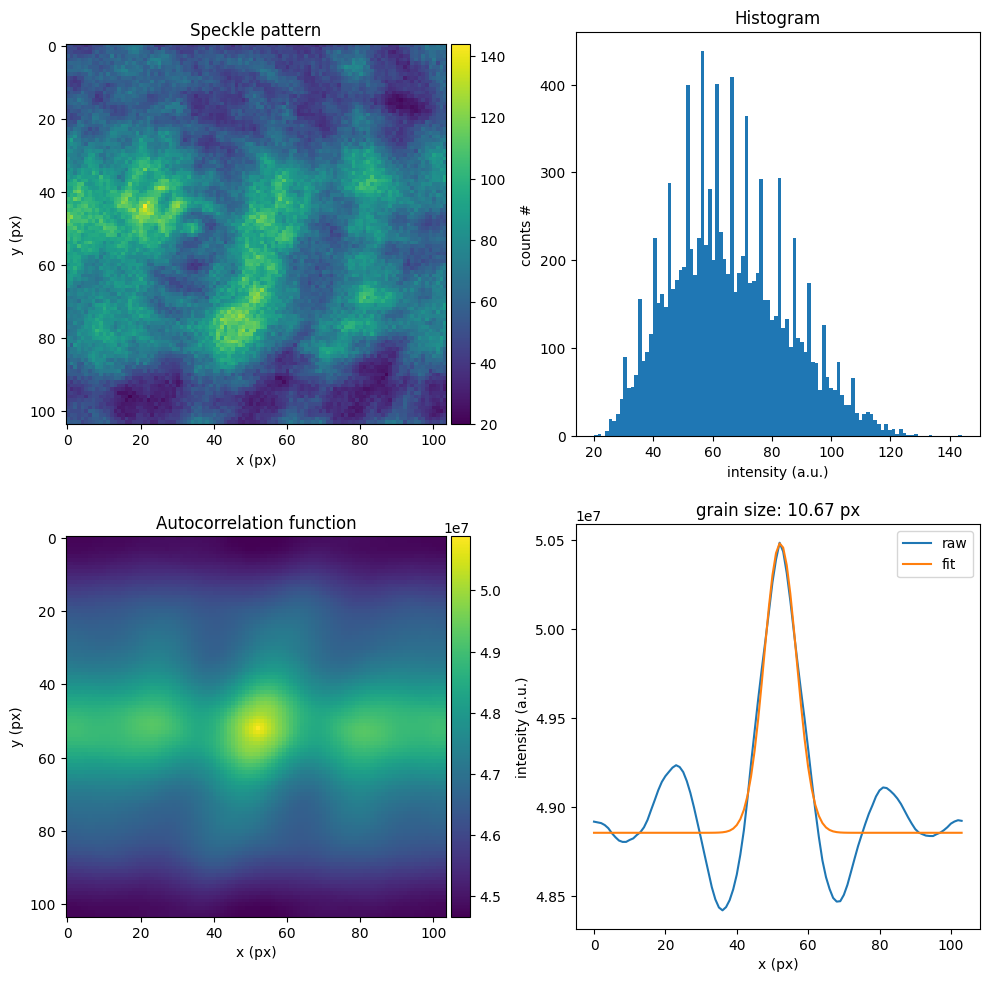

In [14]:
data_out = {}
# save all to dictionary
data_out['speckle'] = speckle
data_out['hist'] = histogram
data_out['acf'] = acf
data_out['fit'] = fit
data_out['grain_size'] = fwhm

# plot and save results
figure = plot(data_out)